# TensorFlow Neural Network Lab

<img src="images/notmnist.png">
In this notebook, we'll use TensorFlow to label images of letters! The dataset used here, <a href="http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html">notMNIST</a>, consists of images of a letter from A to J in different fonts (so, it will have 10 different classes).

Above, you have some images from this dataset. We will train a network and, after that, we will compare your prediction model against test data. Your goal, by the end of this lession, is to make predictions with at least an 80% accuracy. 

## Preprocessing 

Before we start to play with TensorFlow, we have to prepare the data into a suitable format for the tool. Let's do it?


First things first, let's import all the necessary modules. Just run the code below.

In [1]:
import hashlib
import os
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

The notMNIST dataset is way too large for our purpose here. We just want to try TensorFlow and it contains 500,000 images for just training. Therefore, for now on we will be using a subset of this data, 15,000 images for each label (A-J).

After run, wait till the message of successful uncompress.

In [2]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Load image data as 1 dimensional array
                    # We're using float32 to save on memory space
                    feature = np.array(image, dtype=np.float32).flatten()

                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Get the features and labels from the zip files
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples= size_limit)

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

100%|██████████| 10001/10001 [00:01<00:00, 7677.63files/s]


All features and labels uncompressed.


Now, we have to normalizing the features for your training and test data.
We are creating afunction called  `normalize_grayscale()` to range the values of the pixels in the input data should range from 0.1 to 0.9.

Since the raw notMNIST image data is in [grayscale](https://en.wikipedia.org/wiki/Grayscale), the current values range from a min of 0 to a max of 255.

Therefore, we using the formula below to do the Min-Max Scaling:

$
X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}}
$


In [3]:
# Problem 1 - Implement Min-Max scaling for grayscale image data
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

train_features = normalize_grayscale(train_features)
test_features = normalize_grayscale(test_features)

After that, we will turn the labels into numbers and apply One-Hot Encoding into then. Then, we will randomize and split the dataset.

In [4]:
# One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels)
test_labels = encoder.transform(test_labels)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

print('Labels One-Hot Encoded.')

# Randomize and Split the data
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Labels One-Hot Encoded.
Training features and labels randomized and split.



## Let's TensorFlow!

Now it's time to build a simple neural network using TensorFlow. As we are just want to try TensorFlow, our network will be just an input layer and an output layer.

<img src="images/network_diagram.png" style="height: 40%;width: 40%; position: relative; right: 10%">

For the input here the images have been flattened into a vector of $28 \times 28 = 784$ features. Then, we're trying to predict the image digit so there are 10 output units, one for each label.

TensorFlow have some very specific variables types for building the neural network. For this example, we will need the following <a href="https://www.tensorflow.org/resources/dims_types.html#data-types">float32</a> tensors:
 - `features`
  - Placeholder tensor for feature data (`train_features`/`valid_features`/`test_features`)
 - `labels`
  - Placeholder tensor for label data (`train_labels`/`valid_labels`/`test_labels`)
 - `weights`
  - Variable Tensor with random numbers from a truncated normal distribution.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#truncated_normal">`tf.truncated_normal()` documentation</a> for help.
 - `biases`
  - Variable Tensor with all zeros.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#zeros"> `tf.zeros()` documentation</a> for help.

In [5]:
%matplotlib inline

# All the pixels in the image (28 * 28 = 784)
features_count = 784
# All the labels
labels_count = 10

features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)


weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))


# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


## Training our model

Now that we already have our TensorFlow model, it is time to train it. Remember how the number of epochs and the learning rate can influence the learning behavior of the neural net. The figure below illustrates this effect.
<img src="images/Learn_Rate_Tune_Image.png" style="height: 70%;width: 70%">

The code will print out a Loss and Accuracy graph, so you can see how well the neural network performed.

Instructions for updating:
Use tf.cast instead.


Epoch  3/3: 100%|██████████| 1114/1114 [00:03<00:00, 304.90batches/s]


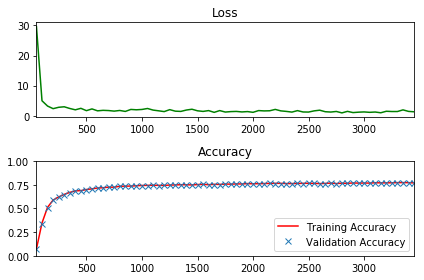

Validation accuracy at 0.7670666575431824


In [7]:
# Change if you have memory restrictions
batch_size = 128

# TODO: Find the best parameters for each configuration
epochs = 3
learning_rate = 0.1


# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

## Test

Finally, we are about to test our model against the testing data. This will give us a good indicator of how well the model will do in the real world.  We expect a test accuracy of at least 80%. If for any reason our neural net doesn't achieve that, we can go back to the last snippet and change some parameters (such as the number of epochs and learning rate) and then train again. 

In [8]:
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


if test_accuracy >= 0.80:
    print('Great! The test accuracy is {}'.format(test_accuracy))
else:
    print('Not bad, but it could be better. Test Accuracy is {}'.format(test_accuracy))

Epoch  3/3: 100%|██████████| 1114/1114 [00:00<00:00, 1710.26batches/s]

Great! The test accuracy is 0.8307999968528748


# Multiple layers
Good job! You built a one layer TensorFlow network! However, you might want to build more than one layer. This is deep learning after all! You can go back to the model definition and try to do this. 